In [1]:
import pyHepMC3.pyHepMC3.HepMC3 as hm3

In [2]:
rdr = hm3.deduce_reader("marley_dar_nue_cc_40Ar.hepmc3")

In [3]:
def EE_MeV(ev):
    elecs = [p for p in ev.particles() if ((p.pid() == 11) and (p.status() == 1))]
    to_MeV = 1 if (ev.momentum_unit() == hm3.Units.MEV) else 1E3
    return elecs[0].momentum().e() * to_MeV

def topo(ev):

    num_e = 0
    num_p = 0
    num_n = 0
    num_alpha = 0

    for p in ev.particles():
        if p.status() != 1:
            continue
        pid = p.pid()
        
        if pid == 11:
            num_e += 1
        elif pid == 2212:
            num_p += 1
        elif pid == 2112:
            num_n += 1
        elif pid == 1000020040:
            num_alpha += 1
        elif (pid == 22) or (pid > 1000000000):
            #ignore gamma/nuclear remnants
            continue

    num_non_e = num_p + num_n + num_alpha

    if num_non_e == 0:
        return 1
    elif num_non_e == 1:
        if num_p == 1:
            return 2
        if num_n == 1:
            return 3
        if num_alpha == 1:
            return 4
    return 5

In [4]:
ev = hm3.GenEvent()

dfi = { "number": [], 
        "weight": [], 
        "topology": [], 
        "EE_MeV": [] }

fatx = 0
fatxu = None

while not rdr.failed():
    rdr.read_event(ev)

    if rdr.failed():
        break

    if not fatx:
        fatx = float(ev.attribute_as_string("NuHepMC.FluxAveragedTotalCrossSection"))
        fatxu = ev.attribute_as_string("NuHepMC.Units.CrossSection.Unit") + " " + \
                ev.attribute_as_string("NuHepMC.Units.CrossSection.TargetScale")

    dfi["number"].append(ev.event_number())
    dfi["weight"].append(ev.weights()[0])
    dfi["topology"].append(topo(ev))
    dfi["EE_MeV"].append(EE_MeV(ev))

print(f"FATX = {fatx} {fatxu}")

FATX = 0.000360586036749582 pb PerTarget


In [6]:
import pandas as pd

df = pd.DataFrame(dfi)
df

,number,weight,topology,EE_MeV
0,1,1.0,1,34.234492
1,2,1.0,2,32.042171
2,3,1.0,3,17.819348
3,4,1.0,3,32.471048
4,5,1.0,1,35.245355
...,...,...,...,...
499995,499996,1.0,3,22.132047
499996,499997,1.0,1,34.913964
499997,499998,1.0,1,42.884392
499998,499999,1.0,2,27.471094


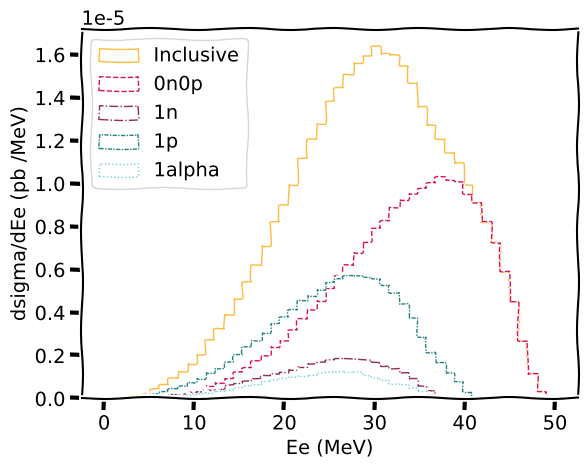

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.xkcd()

wh = {
    "c": ["#ffbc42","#d81159","#8f2d56","#218380","#73d2de"],
    "l": ["Inclusive","0n0p","1n","1p","1alpha"],
    "ls": ["solid","dashed","dashdot",(10, (3, 1, 1, 1)),"dotted"]
}

def scaled_hist(topo):
    dfs = df[df["topology"] == topo] if topo else df
    
    hist, edges = np.histogram(dfs["EE_MeV"], bins=np.linspace(0,50,50), weights=dfs["weight"])
    #divide out bin width for differential xs
    hist = hist * (edges[1:] - edges[:-1]) 
    hist *= fatx/float(df.shape[0])

    return hist, edges

for t in range(0,5):
    h, e = scaled_hist(t)
    plt.hist((e[:-1] + e[1:])/2.0, bins=e, weights=h, color=wh["c"][t], label=wh["l"][t], ls=wh["ls"][t], histtype="step")

plt.xlabel('Ee (MeV)')
plt.ylabel('dsigma/dEe (pb /MeV)')

plt.legend(loc="upper left")

plt.show()